In [3]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

In [4]:
df = pd.read_csv("titanic_toy.csv")[['Age','Fare']]

In [5]:
df.head()

,Age,Fare
0,22.0,7.2500
1,38.0,71.2833
2,26.0,7.9250
3,35.0,53.1000
4,35.0,8.0500


In [6]:
# Display missing values summary
missing_summary = df.isnull().mean()*100

print("Columns with missing values:\n", missing_summary)

Columns with missing values:
 Age     19.865320
Fare     5.050505
dtype: float64


In [7]:
from sklearn.impute import KNNImputer

def handle_missing_values(df, exclude_columns=None, threshold=0.8, use_knn = False, knn_neighbors=3):
    """
    Handles missing values in a DataFrame with the correct method selection.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        exclude_columns (list, optional): List of column names to exclude. Default is None.
        threshold (float, optional): Columns with more than this proportion of missing values are dropped. Default is 0.5.
        use_knn (bool, optional): If True, applies KNN imputation for numerical data. Default is True.
        knn_neighbors (int, optional): Number of neighbors for KNN imputation. Default is 3.

    Returns:
        pd.DataFrame: The DataFrame with missing values handled.
        dict: A dictionary logging the imputation method used for each column.
    """
    if exclude_columns is None:
        exclude_columns = []

    df = df.copy()  # Avoid modifying the original DataFrame
    methods_used = {}  # Dictionary to store methods used for each column

    # Separate categorical and numerical columns
    cat_cols = df.select_dtypes(include=['object']).columns
    num_cols = df.select_dtypes(include=[np.number]).columns

    for col in df.columns:
        missing_ratio = df[col].isnull().mean()
        print(f"\n🔹 Processing Column: {col} (Missing: {missing_ratio:.2%})")

        # Skip excluded columns
        if col in exclude_columns:
            print(f"   → ❌ Excluded from imputation.")
            methods_used[col] = "Excluded"
            continue

        # Drop column if too many missing values
        if missing_ratio > threshold:
            df.drop(columns=[col], inplace=True)
            print(f"   → Dropped (Too many missing values: {missing_ratio:.2%})")
            methods_used[col] = "Dropped (Too many missing values)"
            continue

        # Handle categorical columns
        if col in cat_cols:
            mode_value = df[col].mode()[0]
            df[col].fillna(mode_value, inplace=True)
            print(f"   → 🟠 Categorical: Filled with Mode ({mode_value})")
            methods_used[col] = "Filled with Mode"
            continue  # Move to next column

        # Handle numerical columns
        if col in num_cols:
            skewness = df[col].skew()
            if df[col].isnull().sum() > 0:
                if use_knn:
                    print(f"   → 🔵 Numerical: Applying KNN Imputation")
                    methods_used[col] = "Filled with KNN Imputation"
                elif abs(skewness) > 1:  # Highly skewed data -> Use median
                    median_value = df[col].median()
                    df[col].fillna(median_value, inplace=True)
                    print(f"   → 🟢 Highly Skewed (|{skewness:.2f}| > 1): Filled with Median ({median_value})")
                    methods_used[col] = "Filled with Median"
                else:  # Normal distribution -> Use mean
                    mean_value = df[col].mean()
                    df[col].fillna(mean_value, inplace=True)
                    print(f"   → 🔵 Normally Distributed (|{skewness:.2f}| ≤ 1): Filled with Mean ({mean_value:.2f})")
                    methods_used[col] = "Filled with Mean"

    # Apply KNN imputation for numerical columns
    if use_knn and num_cols.size > 0:
        knn_imputer = KNNImputer(n_neighbors=knn_neighbors)
        df[num_cols] = knn_imputer.fit_transform(df[num_cols])
        print("\n✅ KNN Imputation applied to numerical columns.")
    print("\n🔹 Imputation Methods Used:")

    
    for col, method in methods_used.items():
        print(f"{col}: {method}")

    return df


In [12]:
def compare_covariance_and_density(original_df, imputed_df):
    """
    Compares covariance matrices before and after imputation and plots density graphs.

    Parameters:
        original_df (pd.DataFrame): DataFrame before imputation.
        imputed_df (pd.DataFrame): DataFrame after imputation.
    """
    cov_before = original_df.cov()
    cov_after = imputed_df.cov()

    print("\n🔹 Covariance Matrix Before Imputation:\n", cov_before)
    print("\n🔹 Covariance Matrix After Imputation:\n", cov_after)

    numeric_cols = original_df.select_dtypes(include=[np.number]).columns

    for col in numeric_cols:
        plt.figure(figsize=(8, 5))
        sns.kdeplot(original_df[col].dropna(), color='red', label="Before Imputation")
        sns.kdeplot(imputed_df[col], color='green', label="After Imputation")
        plt.title(f"Density Plot for {col} (Before vs. After Imputation)")
        plt.xlabel(col)
        plt.ylabel("Density")
        plt.legend()
        plt.show()


🔹 Processing Column: Age (Missing: 19.87%)
   → 🔵 Numerical: Applying KNN Imputation

🔹 Processing Column: Fare (Missing: 5.05%)
   → 🔵 Numerical: Applying KNN Imputation

✅ KNN Imputation applied to numerical columns.

🔹 Imputation Methods Used:
Age: Filled with KNN Imputation
Fare: Filled with KNN Imputation

🔹 Covariance Matrix Before Imputation:
              Age         Fare
Age   211.019125    78.071438
Fare   78.071438  2530.673077

🔹 Covariance Matrix After Imputation:
              Age         Fare
Age   176.439915    66.353610
Fare   66.353610  2461.017628


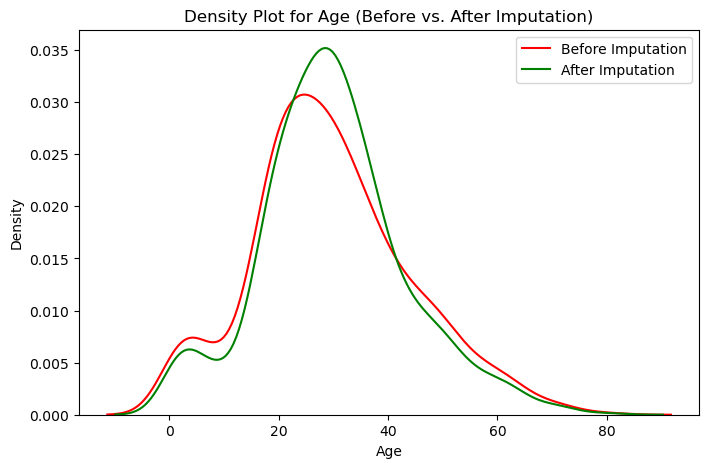

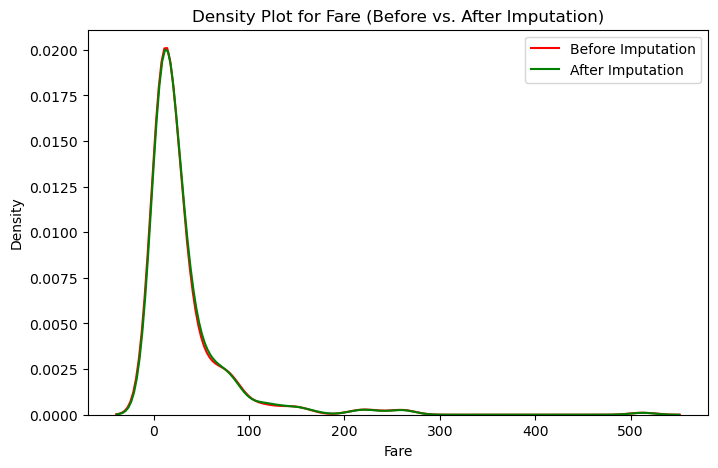

In [18]:
imputed_df = handle_missing_values(df, use_knn = True, knn_neighbors = 7)
compare_covariance_and_density(df, imputed_df)